# Starter Notebook

Install and import required libraries

In [12]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3
!pip install scikit-learn matplotlib seaborn


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

/home/joey/sp25-dl/project2/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-21 21:38:28.671428: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 21:38:28.717100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745285908.739855  554292 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745285908.747516  554292 cuda_blas.cc:1407

## Load Tokenizer and Preprocess Data

In [2]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

In [3]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Make train and eval split

In [4]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=1280, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

print("Number of train samples:", len(train_dataset))
print("Number of eval samples:", len(eval_dataset))

Number of train samples: 118720
Number of eval samples: 1280


## Training Setup

In [5]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }

In [6]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

## Design Space Exploration

### Config

In [8]:
output_base_dir = "dse_results" # base directory for all DSE runs
os.makedirs(output_base_dir, exist_ok=True)

# hyperparameter ranges for DSE
lora_ranks = [4, 5, 6, 7] 
lora_alpha_scaling = [1, 2, 3, 4]


### Design Space Exploration Loop

In [9]:
import gc # Garbage collector for potentially clearing GPU memory

results = []

for rank in lora_ranks:
    for alpha_scale in lora_alpha_scaling:
        alpha = rank * alpha_scale
        run_name = f"rank_{rank}_alpha_{alpha}"
        print(f"\n--- Starting Run: {run_name} ---")

        # Define output directory for this specific run
        current_output_dir = os.path.join(output_base_dir, run_name)
        os.makedirs(current_output_dir, exist_ok=True)

        # 1. Load Base Model (Load fresh for each run)
        print("Loading base model...")

        model = RobertaForSequenceClassification.from_pretrained(
            base_model,
            id2label=id2label)

        # Move model to GPU if possible
        if torch.cuda.is_available():
            model.to('cuda')

        # Configure LoRA
        print(f"Configuring LoRA with r={rank}, alpha={alpha}")
        peft_config = LoraConfig(
            r=rank,  # LoRA rank
            lora_alpha=alpha,  # Alpha parameter for scaling
            lora_dropout=0.1, # Dropout probability for LoRA layers
            target_modules=["query", "key", "value"], # Apply LoRA to these layers
            bias="none",  # Don't train bias parameters
            task_type="SEQ_CLS", # Specify the task type
        )

        peft_model = get_peft_model(model, peft_config)

        print("PEFT Model Configured:")
        peft_model.print_trainable_parameters()

        training_args = TrainingArguments(
            output_dir=current_output_dir,
            report_to=None,
            eval_strategy="steps",
            logging_steps=100,
            learning_rate=1e-5,
            max_steps=1600,
            num_train_epochs=1,
            use_cpu=False,
            dataloader_num_workers=4,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=64, # or 128
            optim="adamw_torch",
            gradient_checkpointing=False,
            gradient_checkpointing_kwargs={'use_reentrant': True},
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False
        )

        trainer = Trainer(
            model=peft_model,
            args=training_args,
            compute_metrics=compute_metrics,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            data_collator=data_collator,
        )

        # 6. Train the model
        print("Starting training...")
        try:
            train_result = trainer.train()
            print("Training finished.")
            trainer.save_model()

            # 7. Evaluate the model after training
            print("Evaluating model on evaluation set...")
            eval_metrics, _ = evaluate_model(
                peft_model,
                eval_dataset,
                labelled=True,
                batch_size=training_args.per_device_eval_batch_size,
                data_collator=data_collator
            )
            final_accuracy = eval_metrics.get('accuracy', float('nan'))

        except Exception as e:
            print(f"!!! ERROR during training/evaluation for {run_name}: {e}")
            final_accuracy = float('nan')  # Record failure

        # 8. Store results
        results.append({
            "lora_rank": rank,
            "lora_alpha": alpha,
            "accuracy": final_accuracy,
            "output_dir": current_output_dir
        })
        print(f"Run {run_name} completed. Accuracy: {final_accuracy:.4f}")

        # 9. Clean up memory (Important!)
        del model
        del peft_model
        del trainer
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Starting Run: rank_4_alpha_4 ---
Loading base model...


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=4, alpha=4
PEFT Model Configured:
trainable params: 814,852 || all params: 125,463,560 || trainable%: 0.6495
Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.389200,1.383539,0.388281
200,1.378700,1.374011,0.319531
300,1.370700,1.364983,0.554688
400,1.362100,1.354770,0.726562
500,1.347600,1.341964,0.726562
600,1.328900,1.323406,0.842969
700,1.311400,1.302116,0.806250
800,1.294100,1.274563,0.857031
900,1.259200,1.242157,0.859375
1000,1.219300,1.200480,0.869531


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Evaluation Metric: {'accuracy': 0.88046875}
Run rank_4_alpha_4 completed. Accuracy: 0.8805

--- Starting Run: rank_4_alpha_8 ---
Loading base model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=4, alpha=8
PEFT Model Configured:
trainable params: 814,852 || all params: 125,463,560 || trainable%: 0.6495
Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.382500,1.379976,0.270313
200,1.378200,1.370393,0.452344
300,1.370700,1.359665,0.586719
400,1.356700,1.343353,0.731250
500,1.331000,1.315576,0.798438
600,1.289700,1.263500,0.865625
700,1.217400,1.171665,0.857031
800,1.103300,1.013957,0.875781
900,0.923600,0.790333,0.872656
1000,0.720700,0.611649,0.884375


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Evaluation Metric: {'accuracy': 0.88671875}
Run rank_4_alpha_8 completed. Accuracy: 0.8867

--- Starting Run: rank_4_alpha_12 ---
Loading base model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=4, alpha=12
PEFT Model Configured:
trainable params: 814,852 || all params: 125,463,560 || trainable%: 0.6495
Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.382400,1.379825,0.271875
200,1.377700,1.369415,0.461719
300,1.368300,1.355699,0.629687
400,1.348500,1.329476,0.781250
500,1.303400,1.270891,0.832812
600,1.202800,1.119587,0.871094
700,0.981200,0.809283,0.863281
800,0.726200,0.568083,0.882031
900,0.566300,0.462727,0.885156
1000,0.467900,0.415150,0.887500


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Evaluation Metric: {'accuracy': 0.88828125}
Run rank_4_alpha_12 completed. Accuracy: 0.8883

--- Starting Run: rank_4_alpha_16 ---
Loading base model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=4, alpha=16
PEFT Model Configured:
trainable params: 814,852 || all params: 125,463,560 || trainable%: 0.6495
Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.382400,1.379663,0.273438
200,1.377300,1.368571,0.474219
300,1.366300,1.351611,0.659375
400,1.339400,1.311400,0.814063
500,1.261400,1.190594,0.857031
600,1.039200,0.831494,0.868750
700,0.704500,0.548062,0.883594
800,0.541500,0.440186,0.886719
900,0.462400,0.397454,0.883594
1000,0.402700,0.377380,0.893750


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Evaluation Metric: {'accuracy': 0.8890625}
Run rank_4_alpha_16 completed. Accuracy: 0.8891

--- Starting Run: rank_5_alpha_5 ---
Loading base model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=5, alpha=5
PEFT Model Configured:
trainable params: 870,148 || all params: 125,518,856 || trainable%: 0.6932
Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.382500,1.380091,0.269531
200,1.378600,1.371076,0.445312
300,1.372100,1.362262,0.552344
400,1.361400,1.350800,0.669531
500,1.344100,1.335078,0.771875
600,1.322400,1.311387,0.855469
700,1.294200,1.280253,0.837500
800,1.262000,1.237182,0.867188
900,1.210200,1.181972,0.868750
1000,1.140600,1.107560,0.872656


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Evaluation Metric: {'accuracy': 0.8796875}
Run rank_5_alpha_5 completed. Accuracy: 0.8797

--- Starting Run: rank_5_alpha_10 ---
Loading base model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=5, alpha=10
PEFT Model Configured:
trainable params: 870,148 || all params: 125,518,856 || trainable%: 0.6932
Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.382400,1.379902,0.271875
200,1.377900,1.369853,0.459375
300,1.369400,1.357451,0.606250
400,1.352500,1.336009,0.762500
500,1.317700,1.293865,0.829688
600,1.250600,1.200329,0.868750
700,1.109300,1.002278,0.864844
800,0.883700,0.709880,0.885938
900,0.668800,0.537909,0.885938
1000,0.530800,0.456280,0.885156


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Evaluation Metric: {'accuracy': 0.8875}
Run rank_5_alpha_10 completed. Accuracy: 0.8875

--- Starting Run: rank_5_alpha_15 ---
Loading base model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=5, alpha=15
PEFT Model Configured:
trainable params: 870,148 || all params: 125,518,856 || trainable%: 0.6932
Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.382400,1.379716,0.273438
200,1.377400,1.368656,0.470313
300,1.366600,1.352188,0.650781
400,1.341000,1.314840,0.808594
500,1.270600,1.207563,0.858594
600,1.073000,0.879516,0.870313
700,0.745900,0.577302,0.881250
800,0.565700,0.452614,0.886719
900,0.475700,0.402215,0.887500
1000,0.410100,0.378950,0.892188


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Evaluation Metric: {'accuracy': 0.89140625}
Run rank_5_alpha_15 completed. Accuracy: 0.8914

--- Starting Run: rank_5_alpha_20 ---
Loading base model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=5, alpha=20
PEFT Model Configured:
trainable params: 870,148 || all params: 125,518,856 || trainable%: 0.6932
Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.382300,1.379519,0.271094
200,1.376600,1.367073,0.486719
300,1.362600,1.344364,0.704688
400,1.322000,1.274340,0.842187
500,1.164300,0.982007,0.861719
600,0.789500,0.582713,0.885938
700,0.542000,0.445232,0.888281
800,0.465700,0.394729,0.892969
900,0.420500,0.372332,0.890625
1000,0.373800,0.360742,0.896875


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Evaluation Metric: {'accuracy': 0.89140625}
Run rank_5_alpha_20 completed. Accuracy: 0.8914

--- Starting Run: rank_6_alpha_6 ---
Loading base model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=6, alpha=6
PEFT Model Configured:
trainable params: 925,444 || all params: 125,574,152 || trainable%: 0.7370
Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.382500,1.380077,0.265625
200,1.378600,1.371000,0.450781
300,1.372000,1.361856,0.553125
400,1.360800,1.349565,0.678125
500,1.341900,1.331857,0.776563
600,1.317000,1.303474,0.860938
700,1.282000,1.263135,0.845313
800,1.237200,1.203205,0.872656
900,1.164100,1.120505,0.870313
1000,1.059800,1.005638,0.875781


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


Evaluation Metric: {'accuracy': 0.884375}
Run rank_6_alpha_6 completed. Accuracy: 0.8844

--- Starting Run: rank_6_alpha_12 ---
Loading base model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=6, alpha=12
PEFT Model Configured:
trainable params: 925,444 || all params: 125,574,152 || trainable%: 0.7370
Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.382400,1.379839,0.272656
200,1.377800,1.369601,0.462500
300,1.368700,1.356128,0.621875
400,1.349500,1.330694,0.778125
500,1.306200,1.274591,0.842187
600,1.209400,1.127160,0.871094
700,0.990100,0.815176,0.867969
800,0.730700,0.569564,0.886719
900,0.567900,0.461012,0.882031
1000,0.465400,0.411694,0.886719


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


Evaluation Metric: {'accuracy': 0.88671875}
Run rank_6_alpha_12 completed. Accuracy: 0.8867

--- Starting Run: rank_6_alpha_18 ---
Loading base model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=6, alpha=18
PEFT Model Configured:
trainable params: 925,444 || all params: 125,574,152 || trainable%: 0.7370
Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.382300,1.379616,0.272656
200,1.377100,1.367993,0.475781
300,1.364900,1.348720,0.681250
400,1.332900,1.297932,0.828125
500,1.225400,1.110211,0.861719
600,0.913000,0.681486,0.879687
700,0.608100,0.482098,0.881250
800,0.493700,0.410057,0.888281
900,0.435000,0.380973,0.885156
1000,0.382100,0.366213,0.892188


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


Evaluation Metric: {'accuracy': 0.8875}
Run rank_6_alpha_18 completed. Accuracy: 0.8875

--- Starting Run: rank_6_alpha_24 ---
Loading base model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=6, alpha=24
PEFT Model Configured:
trainable params: 925,444 || all params: 125,574,152 || trainable%: 0.7370
Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.382300,1.379535,0.273438
200,1.376500,1.366943,0.474219
300,1.361600,1.341418,0.717187
400,1.311400,1.247735,0.843750
500,1.087400,0.837407,0.864062
600,0.679900,0.506935,0.885156
700,0.489900,0.415279,0.885156
800,0.436700,0.378751,0.889844
900,0.402300,0.362760,0.892188
1000,0.357800,0.353359,0.892969


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


Evaluation Metric: {'accuracy': 0.89140625}
Run rank_6_alpha_24 completed. Accuracy: 0.8914

--- Starting Run: rank_7_alpha_7 ---
Loading base model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=7, alpha=7
PEFT Model Configured:
trainable params: 980,740 || all params: 125,629,448 || trainable%: 0.7807
Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.382500,1.380028,0.268750
200,1.378400,1.370747,0.450000
300,1.371400,1.360977,0.565625
400,1.359200,1.346997,0.700000
500,1.337400,1.325370,0.789062
600,1.306000,1.287992,0.863281
700,1.257500,1.229877,0.854688
800,1.188600,1.137259,0.871875
900,1.075000,1.001371,0.870313
1000,0.914400,0.818176,0.880469


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


Evaluation Metric: {'accuracy': 0.8890625}
Run rank_7_alpha_7 completed. Accuracy: 0.8891

--- Starting Run: rank_7_alpha_14 ---
Loading base model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=7, alpha=14
PEFT Model Configured:
trainable params: 980,740 || all params: 125,629,448 || trainable%: 0.7807
Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.382400,1.379775,0.271875
200,1.377500,1.369081,0.467969
300,1.367500,1.354156,0.639062
400,1.345100,1.322984,0.799219
500,1.288600,1.243766,0.848437
600,1.143700,1.008391,0.869531
700,0.844700,0.656723,0.871094
800,0.617100,0.487302,0.883594
900,0.501700,0.419914,0.884375
1000,0.424400,0.389509,0.882812


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


Evaluation Metric: {'accuracy': 0.88671875}
Run rank_7_alpha_14 completed. Accuracy: 0.8867

--- Starting Run: rank_7_alpha_21 ---
Loading base model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=7, alpha=21
PEFT Model Configured:
trainable params: 980,740 || all params: 125,629,448 || trainable%: 0.7807
Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.382400,1.379520,0.270313
200,1.376700,1.367364,0.489063
300,1.363000,1.345208,0.704688
400,1.322700,1.276606,0.843750
500,1.162400,0.975317,0.860156
600,0.773200,0.566634,0.883594
700,0.527400,0.438160,0.882812
800,0.455500,0.391376,0.887500
900,0.413200,0.371118,0.885156
1000,0.366100,0.360353,0.892188


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Evaluation Metric: {'accuracy': 0.88671875}
Run rank_7_alpha_21 completed. Accuracy: 0.8867

--- Starting Run: rank_7_alpha_28 ---
Loading base model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=7, alpha=28
PEFT Model Configured:
trainable params: 980,740 || all params: 125,629,448 || trainable%: 0.7807
Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.382200,1.379219,0.273438
200,1.375800,1.365332,0.498437
300,1.357000,1.332309,0.764844
400,1.279500,1.169600,0.854688
500,0.941600,0.671060,0.868750
600,0.574600,0.452959,0.885938
700,0.445500,0.396441,0.887500
800,0.415800,0.370583,0.889844
900,0.388600,0.358791,0.889844
1000,0.347600,0.351612,0.891406


Training finished.
Evaluating model on evaluation set...


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]

Evaluation Metric: {'accuracy': 0.8921875}
Run rank_7_alpha_28 completed. Accuracy: 0.8922


## Post-DSE Analysis

In [ ]:
# Convert results to DataFrame for easy viewing/sorting
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="accuracy", ascending=False)

print(results_df)

# Save results to CSV
results_csv_path = os.path.join(output_base_dir, "dse_summary.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"\nFull DSE results saved to: {results_csv_path}")


    lora_rank  lora_alpha  accuracy                   output_dir
15          7          28  0.892188  dse_results/rank_7_alpha_28
6           5          15  0.891406  dse_results/rank_5_alpha_15
11          6          24  0.891406  dse_results/rank_6_alpha_24
7           5          20  0.891406  dse_results/rank_5_alpha_20
3           4          16  0.889062  dse_results/rank_4_alpha_16
12          7           7  0.889062   dse_results/rank_7_alpha_7
2           4          12  0.888281  dse_results/rank_4_alpha_12
5           5          10  0.887500  dse_results/rank_5_alpha_10
10          6          18  0.887500  dse_results/rank_6_alpha_18
13          7          14  0.886719  dse_results/rank_7_alpha_14
1           4           8  0.886719   dse_results/rank_4_alpha_8
9           6          12  0.886719  dse_results/rank_6_alpha_12
14          7          21  0.886719  dse_results/rank_7_alpha_21
8           6           6  0.884375   dse_results/rank_6_alpha_6
0           4           4

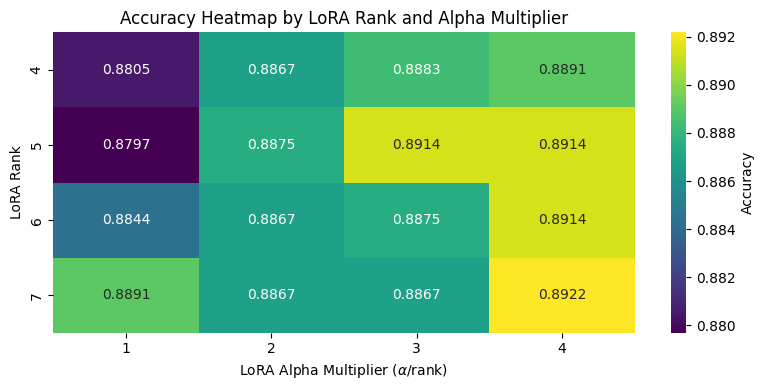

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

results_csv_path = os.path.join("dse_results_do0.1", "dse_summary.csv")
df = pd.read_csv(results_csv_path)

# Add lora_alpha_multiplier column
df["lora_alpha_multiplier"] = df["lora_alpha"] // df["lora_rank"]

# Pivot the data
pivot = df.pivot(index="lora_rank", columns="lora_alpha_multiplier", values="accuracy")

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'Accuracy'})
plt.title("Accuracy Heatmap by LoRA Rank and Alpha Multiplier")
plt.xlabel(r"LoRA Alpha Multiplier ($\alpha$/rank)")
plt.ylabel("LoRA Rank")
plt.tight_layout()
plt.savefig('dse_heatmap.pdf')
plt.show()

### Run Inference on unlabelled dataset

In [ ]:
# Load best model from DSE
model_path = "dse_results/rank_6_alpha_6"

print(f"Loading best model from: {model_path}")
# Load the base model again
base_inference_model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label,
    num_labels=num_labels
)
# Load the PEFT adapter
inference_model = PeftModel.from_pretrained(base_inference_model, model_path)
inference_model.merge_and_unload() # Optional: Merge adapter weights for potentially faster inference

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading best model from: dse_results/rank_4_alpha_8


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [34]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map: 100%|██████████| 8000/8000 [00:02<00:00, 3499.23 examples/s]


Dataset({
    features: ['text'],
    num_rows: 8000
})

In [35]:
# Run inference and save predictions
preds = evaluate_model(inference_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(model_path,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [01:38<00:00, 10.20it/s]

Inference complete. Predictions saved to inference_output.csv
